In [2]:
import os
import numpy as np
from scipy.io import wavfile
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [7]:
# === Датасет ===
class AudioDataset(Dataset):
    def __init__(self, wav_folder, txt_folder, use_spectrogram=False, fit_scaler=False):
        self.wav_folder = wav_folder
        self.txt_folder = txt_folder
        self.wav_files = sorted([f for f in os.listdir(wav_folder) if f.endswith('.wav')])

        self.data = []
        self.labels = []

        if use_spectrogram:
            self.spectrogram_transform = torchaudio.transforms.Spectrogram(
                n_fft=1024,
                hop_length=512,
                power=2
            )

        # Загрузка и обработка всех данных сразу
        max_len = 0
        targets = []
        for file in tqdm(self.wav_files, desc="Loading data"):
            wav_path = os.path.join(wav_folder, file)
            txt_path = os.path.join(txt_folder, file.replace('.wav', '.txt'))

            sample_rate, data = wavfile.read(wav_path)
            if data.ndim > 1:
                data = data[:, 0]
            max_len = max(max_len, len(data))

            target = np.loadtxt(txt_path, dtype=float)
            if len(target) < 44:
                target = np.pad(target, (0, 44 - len(target)), mode='constant')
            
            self.data.append(data)
            targets.append(target)

        if fit_scaler:
            self.scaler = StandardScaler()
            self.scaler.fit(targets)

        self.labels = [torch.from_numpy(self.scaler.transform(target.reshape(1, -1))).squeeze(0) for target in targets]

        for i in tqdm(range(len(self.data)), desc="Processing data"):

            # Паддинг до максимальной длины
            pad_length = max_len - len(data)
            data = np.pad(data, (0, pad_length), mode='constant', constant_values=0)

            if use_spectrogram:
                data_tensor = torch.from_numpy(data).float()
                spec = self.spectrogram_transform(data_tensor)
                spec = spec.log2().clamp(min=-10)  # логарифм спектрограммы
                spec = (spec - spec.mean()) / (spec.std() + 1e-6)

                target_length = 1024 
                current_length = spec.size(1)

                if current_length > target_length:
                    # Обрезаем
                    spec = spec[:, :target_length]
                else:
                    # Дополняем нулями справа
                    pad_size = target_length - current_length
                    spec = torch.nn.functional.pad(spec, (0, pad_size), value=-10)
                
                spec = spec.unsqueeze(0)
                self.data[i] = spec
            else:
                N = len(data)
                fft_data = np.fft.fft(data)
                fft_magnitude = np.abs(fft_data[:N//2]) / N
                fft_magnitude = torch.from_numpy(fft_magnitude).float()
                fft_magnitude = fft_magnitude.unsqueeze(0)
                self.data[i] = fft_magnitude


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

модель цнн + трансформер

In [4]:
# === Модель ===
class AudioRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))
            
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1, batch_first=True),
            num_layers=3
        )
        self.fc = nn.Linear(128, 44)

    def forward(self, x):
        x = self.cnn(x)     # [B, 128, 1, T]
        x = x.squeeze(2)    # [B, 128, T]
        x = x.permute(0,2,1)  # [B, T, 128] для batch_first
        x = self.transformer(x)
        x = x.mean(dim=1)   # [B, 128]
        out = self.fc(x)
        return out

CNN

In [60]:
# === Модель ===
class AudioRegressor_CNN(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, H, W)
        x = self.cnn(x)     # [B, 128, 1, T]
        # x = x.squeeze(2)    # [B, 128, T]
        # x = x.permute(0,2,1)  # [B, T, 128] для batch_first
        # x = x.mean(dim=1)   # [B, 128]
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

In [5]:
class AudioRegressor_1DCNN(nn.Module):
    def __init__(self, input_length=346858, output_size=44):
        super().__init__()
        
        self.main = nn.Sequential(
            # Блок 1
            nn.Conv1d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Блок 2
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Блок 3
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Автоматический расчет размера после сверток
        with torch.no_grad():
            x = torch.randn(1, 1, input_length)
            x = self.main(x)
            flat_size = x.view(1, -1).size(1)
        
        self.fc = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        # x shape: [batch, 1, 346858]
        x = self.main(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:
class CNN2D(nn.Module):
    def __init__(self, output_size):
        super(CNN2D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.fc = nn.Linear(32 * 4 * 4, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, H, W)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        
        # LSTM для каждой частотной компоненты
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=1,
            dropout=0.3
        )
        
        # Полносвязный слой
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: [batch, 1, freq_bins]
        x = x.squeeze(1)  # [batch, freq_bins]
        
        # Обрабатываем каждую частоту отдельно
        batch_size, freq_bins = x.size()
        # x = x.permute(0, 2, 1)  # [batch, freq_bins]
        
        # LSTM
        lstm_out, _ = self.lstm(x)  # [batch, time_steps, hidden_size]
        
        # Объединяем все частотные компоненты
        out = lstm_out.reshape(batch_size, -1)
        
        return self.fc(out)

In [ ]:
# === Константы ===
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3

WAV_DIR = "data/wav"
TXT_DIR = "data/txt"
print(DEVICE)

cuda


In [8]:
# === Загрузка данных ===
# 1. Создаем общий датасет
full_dataset = AudioDataset(WAV_DIR, TXT_DIR, use_spectrogram=True, fit_scaler=True)
scaler = full_dataset.scaler

# 2. Разделяем train/test
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Processing data: 100%|██████████| 3868/3868 [00:40<00:00, 94.53it/s] 


In [7]:
full_dataset.data[0]

tensor([[[ 31.9765,  31.9896,  31.9876,  ..., -10.0000, -10.0000, -10.0000],
         [ 29.9627,  29.9900,  29.9867,  ..., -10.0000, -10.0000, -10.0000],
         [ 16.5190,   9.4869,   9.1544,  ..., -10.0000, -10.0000, -10.0000],
         ...,
         [  5.5230,   3.5330,   2.2983,  ..., -10.0000, -10.0000, -10.0000],
         [  5.1350,   5.7586,   2.3176,  ..., -10.0000, -10.0000, -10.0000],
         [  5.3137,   6.2223,   4.7911,  ..., -10.0000, -10.0000, -10.0000]]])

In [8]:
example_input, example_target = full_dataset.data[0], full_dataset.labels[0]
input_size_fft = example_input.shape[0]
output_size = example_target.shape[0]
print(example_input, example_target)
print(input_size_fft, output_size)

tensor([[[ 31.9765,  31.9896,  31.9876,  ..., -10.0000, -10.0000, -10.0000],
         [ 29.9627,  29.9900,  29.9867,  ..., -10.0000, -10.0000, -10.0000],
         [ 16.5190,   9.4869,   9.1544,  ..., -10.0000, -10.0000, -10.0000],
         ...,
         [  5.5230,   3.5330,   2.2983,  ..., -10.0000, -10.0000, -10.0000],
         [  5.1350,   5.7586,   2.3176,  ..., -10.0000, -10.0000, -10.0000],
         [  5.3137,   6.2223,   4.7911,  ..., -10.0000, -10.0000, -10.0000]]]) tensor([[-2.5428,  0.1551,  0.0242, -0.4640,  0.4544, -0.2272,  1.3692, -0.0529,
         -0.0929, -1.3438, -2.9646,  1.2216,  0.4343, -0.0183, -0.0601, -0.2128,
          0.5133, -0.1860,  0.0374,  1.1829,  1.4760, -0.8847, -0.5893,  0.2214,
          0.5514, -0.5537, -0.5224, -0.0704, -0.0450, -0.0303, -0.0509,  0.2234,
          0.5269,  1.7399, -2.3378,  0.3022,  0.0163,  0.0624,  0.1277,  0.2645,
         -1.6380,  0.4868,  0.5211,  0.5221]], dtype=torch.float64)
1 1


In [9]:
sample_x, sample_y = next(iter(train_loader))
print("Input shape:", sample_x.shape)  # Должно быть [batch, channels, freq, time]
print("Target shape:", sample_y.shape)

Input shape: torch.Size([32, 1, 513, 1024])
Target shape: torch.Size([32, 44])


In [ ]:
# === Обучение ===
# model = LSTMModel(input_size=sample_x.shape[2], hidden_size=256, output_size=sample_y.shape[1])
# model = AudioRegressor_1DCNN(input_length=sample_x.shape[2], output_size=sample_y.shape[1])
model = AudioRegressor()

In [ ]:
# Для ранней остановки
def train(model, train_loader, val_loader, model_name, scaler=None, lr=LEARNING_RATE, EPOCHS=10):
    best_val_loss = float('inf')
    patience = 3
    no_improve = 0
    best_model_weights = None

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()


    train_losses = []
    val_losses = []
    mae_scores = []
    r2_scores = []

    for epoch in range(EPOCHS):
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()
            preds = model(xb)

            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)

                loss = criterion(preds, yb)
                val_loss += loss.item()

                all_preds.append(preds.squeeze(1).cpu().numpy())
                all_targets.append(yb.squeeze(1).cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
            best_model_weights = model.state_dict().copy()  # Сохраняем веса
            torch.save(model.state_dict(), model_name + '.pth')  # Сохраняем модель
            torch.save(model, model_name + '.pt')  # Сохраняем модель
            print(f"New best model! Val Loss: {val_loss:.4f}")
        else:
            no_improve += 1
            print(f"No improvement for {no_improve}/{patience} epochs")
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_weights)  # Восстанавливаем лучшие веса
                break

        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        # ДЕНОРМАЛИЗАЦИЯ
        if scaler:
            all_preds = scaler.inverse_transform(all_preds)
            all_targets = scaler.inverse_transform(all_targets)

        mae = mean_absolute_error(all_targets, all_preds)
        r2 = r2_score(all_targets, all_preds)

        mae_scores.append(mae)
        r2_scores.append(r2)

        print(f"[Epoch {epoch+1}] Train Loss: {epoch_train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

    with open(model_name + '_architecture.json', 'w') as f:
        f.write(str(model))
        
    return train_losses, val_losses, mae_scores, r2_scores

In [14]:
train_losses, val_losses, mae_scores, r2_scores = train(model, train_loader, val_loader, 'CNNTransformerScaler')

New best model! Val Loss: 1.0753
[Epoch 1] Train Loss: 0.9989 | Val Loss: 1.0753 | MAE: 0.5365 | R²: -0.0073
No improvement for 1/3 epochs
[Epoch 2] Train Loss: 0.9852 | Val Loss: 1.0754 | MAE: 0.5049 | R²: -0.0073


KeyboardInterrupt: 

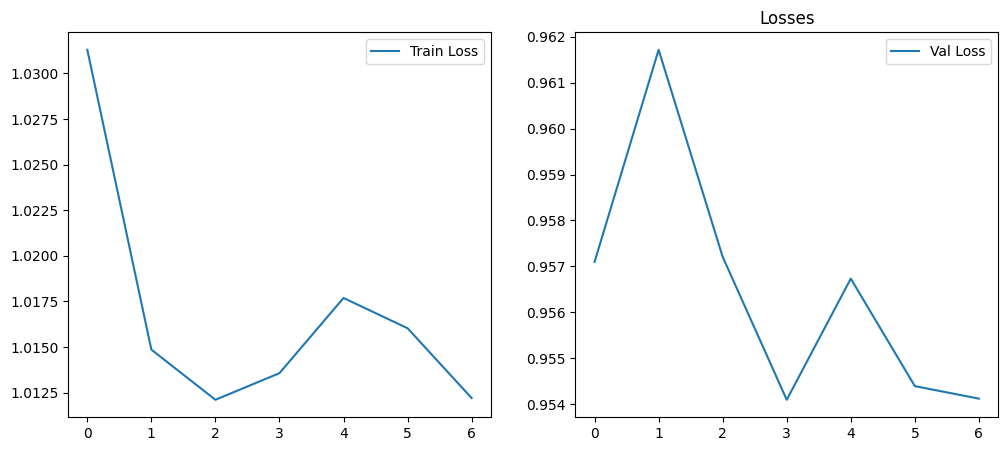

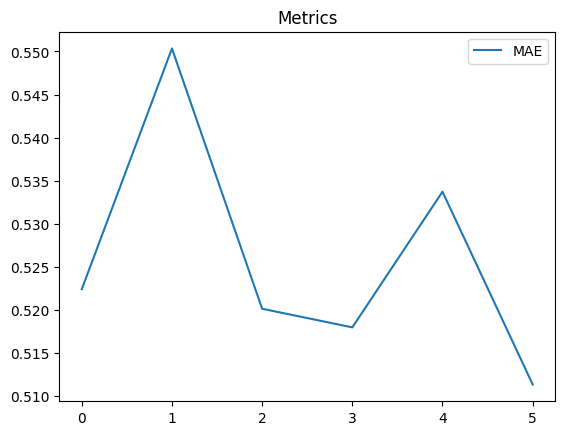

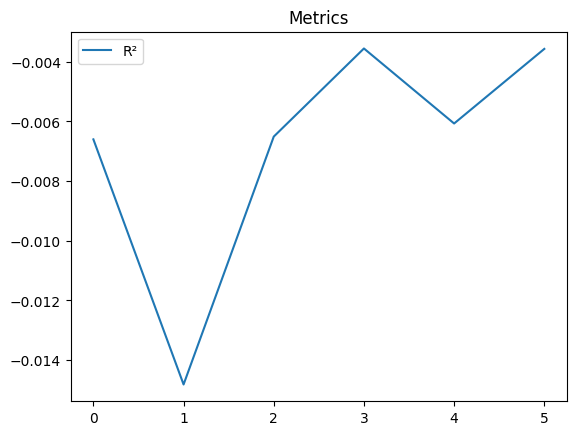

In [33]:
# === Графики ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Losses")

plt.show()


plt.plot(mae_scores, label='MAE')
plt.legend()
plt.title("Metrics")
plt.show()


plt.plot(r2_scores, label='R²')
plt.legend()
plt.title("Metrics")
plt.show()

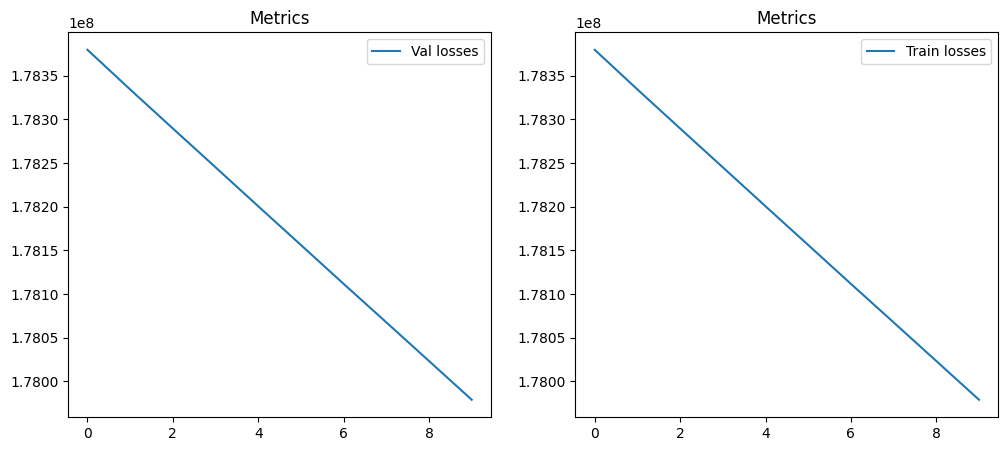

In [52]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(val_losses, label='Val losses')
plt.legend()
plt.title("Metrics")

plt.subplot(1,2,2)
plt.plot(val_losses, label='Train losses')
plt.legend()
plt.title("Metrics")
plt.show()